In [1]:
import numpy as np

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [149]:
# constant diffusion
g = 0.25

# levy alpha parameter
alpha = 1.0

# time step
h = 0.001

# for stretch = 1, this is an equispaced grid on the closed interval [-lmax, lmax]
# for stretch > 1, this is a way to create a non-equispaced grid on [-lmax, lmax]
#                  that is highly concentrated near the origin
npts = 257
stretch = 1.0
lmax = 4

du = 2.0/(npts - 1)
startvec = -1.0 + np.arange(npts)*du
uvec = lmax*np.sign(startvec)*(np.abs(startvec)**stretch)
ugrid1, ugrid2 = np.meshgrid(uvec, uvec)

# this is a scaling factor used in all the collocation functions below
zeta = 1.0

In [136]:
# define true drift
def truef(x):
    return np.sin(x)

In [150]:
# these parameters define the RBF or Gaussian grid that we use to approximate the drift f(x)
L = 2
xmax = L*np.pi
xpts = 17
xvec = np.linspace(-xmax, xmax, xpts)

# key parameter that is used below, controls how close the Gaussians are
sigma = 0.5

# actual approximation of f is via one call to np.linalg.solve
xgrid1, xgrid2 = np.meshgrid(xvec, xvec)
gaussmat = np.exp(-(xgrid1 - xgrid2)**2/(2*sigma**2))
print(np.linalg.cond(gaussmat))
f = truef(xvec)
thetatrue = np.linalg.solve(gaussmat, f)

print(np.linalg.norm( f - gaussmat@thetatrue) )

3.607535314227469
5.474610673589985e-16


In [151]:
# fine grid for plotting
xplotpts = 256
xplotvec = np.linspace(-xmax, xmax, xplotpts)
xplotgrid1, xplotgrid2 = np.meshgrid(xvec, xplotvec)
gaussplotmat = np.exp(-(xplotgrid1 - xplotgrid2)**2/(2*sigma**2))
fplot = truef(xplotvec)
approxplot = gaussplotmat @ thetatrue

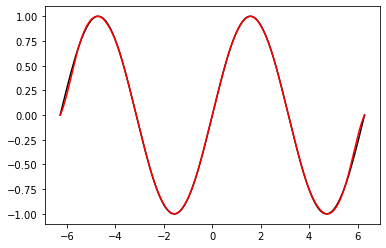

In [152]:
plt.plot(xplotvec, fplot, color='black')
plt.plot(xplotvec, approxplot, color='red')
plt.show()

In [153]:
# set up objects that do not depend on theta outside the function

# here we set up (s-u)*x    
inner = np.einsum('jk,i->jki',ugrid1-ugrid2,xvec)

# normalization times Gaussian term
firstpart = np.sqrt(2*np.pi*sigma**2)*np.exp(-(sigma**2/2)*(ugrid1-ugrid2)**2)
    
# return fhat(s-u) as a matrix
def fhat(theta):
    # now compute complex exponential and sum against theta
    sumout = np.einsum('i,jki->jk',theta,np.exp(1j*inner))
    # final result
    return firstpart*sumout

In [154]:
# additional decay term
decayterm = np.exp(-(xgrid1-xgrid2)**2/(4*sigma**2))

# slightly modified term from above
firstpart2 = np.sqrt(np.pi*sigma**2)*np.exp(-(sigma**2/4)*(ugrid1-ugrid2)**2)

# return f2hat(s-u) as a matrix
def f2hat(theta):
    # einsum won't work so let's use a double for loop
    sumout = np.zeros((npts,npts), dtype=np.complex128)
    for i in range(xpts):
        for j in range(xpts):
            sumout += theta[i]*theta[j]*np.exp(0.5j*(ugrid1-ugrid2)*(xvec[i]+xvec[j]))*decayterm[i,j]

    return firstpart2*sumout

In [155]:
fhatmat = fhat(thetatrue)

In [156]:
f2hatmat = f2hat(thetatrue)

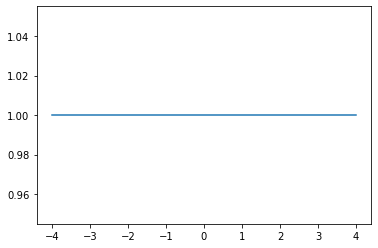

In [157]:
# start with a nice Gaussian initial condition
psi0 = np.ones(npts) # np.exp(-0.1*uvec**2)
plt.plot(uvec, psi0)
plt.show()

In [158]:
psi0[npts//2]

1.0

In [159]:
du

0.0078125

In [160]:
psi = np.copy(psi0)
numsteps = 4000
for j in range(numsteps):
    part1 = (1j*uvec*h/(2*np.pi))*fhatmat @ psi
    part2 = -0.5*(uvec**2)*h**2/(2*np.pi)*f2hatmat @ psi
    psinew = psi + (part1 + part2)*du
    psi = np.exp(-h*np.abs(uvec*g)**alpha) * psinew
    if j % 10 == 0:
        print(psi[npts//2])

(0.9997575891708905-1.702630098769157e-36j)
(0.9973398241191681-6.596727360020825e-36j)
(0.9949335452780138-1.7894697439361536e-35j)
(0.9925386859371104-2.6178626534796975e-35j)
(0.9901551798526295-2.18498685878939e-35j)
(0.9877829612435808-1.3754018588590028e-35j)
(0.9854219647881899-2.2628266253329035e-35j)
(0.9830721256203072-2.2652143482330112e-35j)
(0.9807333793258464-2.2481329459476249e-35j)
(0.9784056619392496-2.2728917957118193e-35j)
(0.976088909939983-2.0298216044808482e-35j)
(0.9737830602490615-1.7700373529491226e-35j)
(0.9714880502255996-1.675299855112539e-35j)
(0.9692038176633923-1.206975558905247e-35j)
(0.9669303007875222-7.533816762816967e-36j)
(0.9646674382509961+4.105046678262207e-36j)
(0.962415169131407-3.549625597498676e-36j)
(0.9601734329276245+4.345288336211512e-36j)
(0.9579421695565125+1.4303562197599447e-35j)
(0.9557213193496713+2.6055566969945267e-35j)
(0.9535108230502096+2.934070633850893e-35j)
(0.9513106218095408+2.4260734033033486e-35j)
(0.9491206571842045+2.2

(0.6760458059412588-9.164921703758434e-34j)
(0.6750496783101382-9.276933458422336e-34j)
(0.6740575504161904-9.306059086028843e-34j)
(0.6730694039320924-9.38409262546925e-34j)
(0.6720852206330624-9.525737858033412e-34j)
(0.671104982396162-9.636849624834966e-34j)
(0.6701286711996034-9.753102342711444e-34j)
(0.6691562691220625-9.826999611404894e-34j)
(0.6681877583419982-9.953131073603088e-34j)
(0.667223121136975-1.0057607725807226e-33j)
(0.6662623398829929-1.014324248926463e-33j)
(0.6653053970538212-1.0266464602944538e-33j)
(0.6643522752203385-1.0382546506798162e-33j)
(0.6634029570498765-1.0404809267776782e-33j)
(0.6624574253055708-1.0490439439459378e-33j)
(0.6615156628457143-1.0596768413621023e-33j)
(0.6605776526231186-1.0691941211709396e-33j)
(0.6596433776844774-1.0756683399790856e-33j)
(0.6587128211697368-1.0855571862053781e-33j)
(0.6577859663114702-1.1010063043820524e-33j)
(0.6568627964342569-1.1093762833373878e-33j)
(0.6559432949540674-1.121357509508144e-33j)
(0.6550274453776515-1.13

(0.544690246029391-2.592890400981306e-33j)
(0.5442030483134502-2.6039855753262557e-33j)
(0.5437176764327004-2.613760912879297e-33j)
(0.5432341231845188-2.621044730462698e-33j)
(0.5427523813990283-2.6288827752654122e-33j)
(0.5422724439389164-2.6390080978943115e-33j)
(0.5417943036992562-2.6499114049289132e-33j)
(0.541317953607328-2.6595601931682488e-33j)
(0.5408433866224428-2.6674094189426203e-33j)
(0.5403705957357655-2.6799720556395528e-33j)
(0.5398995739701412-2.690912900433209e-33j)


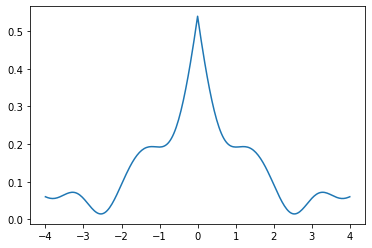

In [161]:
plt.plot(uvec, np.abs(psi))
plt.show()

In [162]:
ftmat = np.exp(-1j * np.expand_dims(uvec,1) @ np.expand_dims(xplotvec, 0))

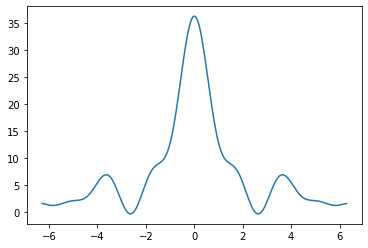

In [163]:
plt.plot(xplotvec, np.real(psi @ ftmat))
plt.show()